# ARIMA forecasting 📈

Objectives:
* Walk-through the steps involved in time series forecasting
* Introduce ARIMA models
* Use an arima model to make a forecast
* Excercise: forecasting animal skins (time to practice!)
# 🐱

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns
import matplotlib.style as style
# style.use('ggplot')

!pip install pmdarima==1.5.2
import pmdarima as pmd
pmd.__version__  #should be version 1.5.2


'1.5.2'



Time-series (or other intrinsically ordered data) can be problematic for cross-validation. If some pattern emerges in year 3 and stays for years 4-6, then your model can pick up on it, even though it wasn't part of years 1 & 2.

An approach that's sometimes more principled for time series is forward chaining, where your procedure would be something like this:

    fold 1 : training [1], test [2]
    fold 2 : training [1 2], test [3]
    fold 3 : training [1 2 3], test [4]
    fold 4 : training [1 2 3 4], test [5]
    fold 5 : training [1 2 3 4 5], test [6]

That more accurately models the situation you'll see at prediction time, where you'll model on past data and predict on forward-looking data. It also will give you a sense of the dependence of your modeling on data size.


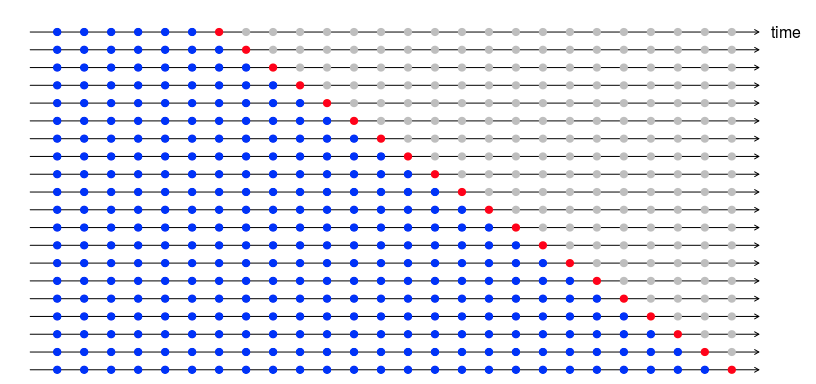

If you need to forecast 4 steps ahead:

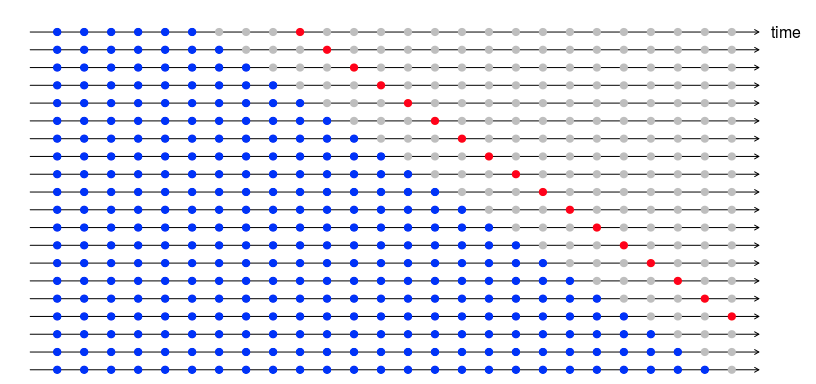

# Example 1 - airline passenger forecasts ✈️ 💺

Our goal here is to forecast the number of air-travel passengers (per month) over the next 12 months using historical data.

Get the airline passenger data




In [4]:
from pmdarima.datasets import load_airpassengers

START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

#there's no datetimeindex from the bundled dataset. So let's add one.
airline.index= pd.date_range(START_DATE, periods=len(airline), freq='MS')

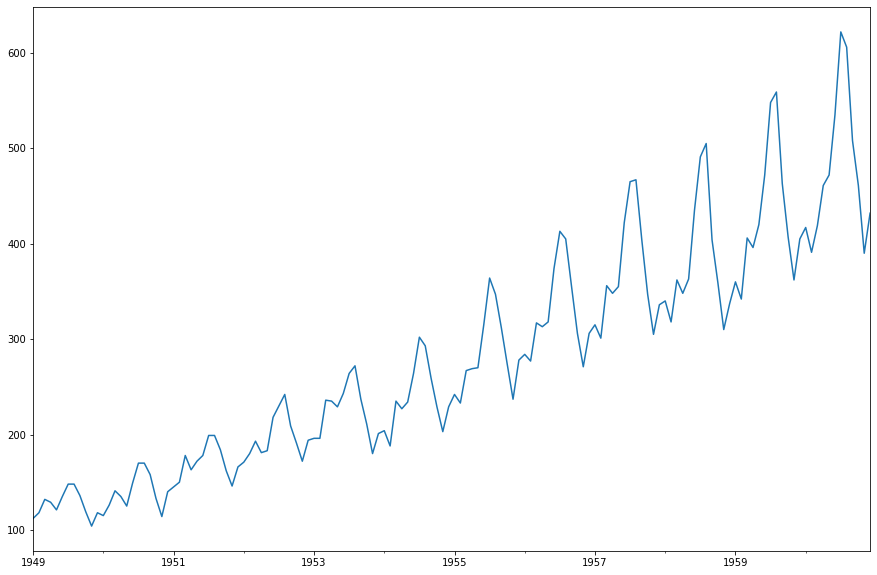

In [10]:
plt.figure(figsize=(15, 10))
airline.plot()

Rather than a random train test split, when analysing time series data we must use the most recent data as the **testing set**.

In [11]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [13]:
# hold back the last twelve months as a TEST set
train, test = ts_train_test_split(airline, '1960-01-01')

In [6]:
#### check trian and test sizes are what we expect
len(train)

132

In [7]:
len(test)

12

## Explore TRAIN data

Like any prediction process we explore the data set to gain insights. But (as always) we only plot the TRAIN data! 

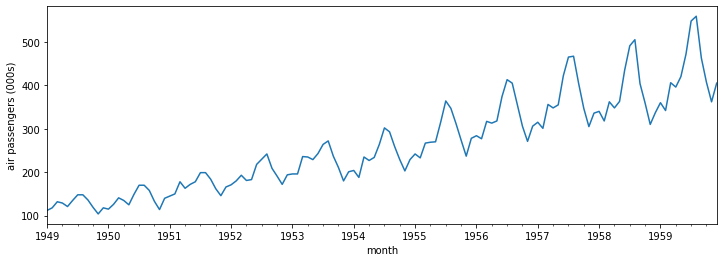

In [14]:
ax = train.plot(figsize=(12,4))
ax.set(xlabel='month', ylabel='air passengers (000s)');

Different months have different numbers of days. Soetimes we need to do what we can to make things easier for our model. Calcuating number of passengers per day might help remove some variation from the series...

In [17]:
train.index.days_in_month

Int64Index([31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
            ...
            31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           dtype='int64', length=132)

In [1]:
train

NameError: name 'train' is not defined

In [134]:
len(train_adj)

132

In [135]:
train.index.days_in_month

Int64Index([31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
            ...
            31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           dtype='int64', length=132)

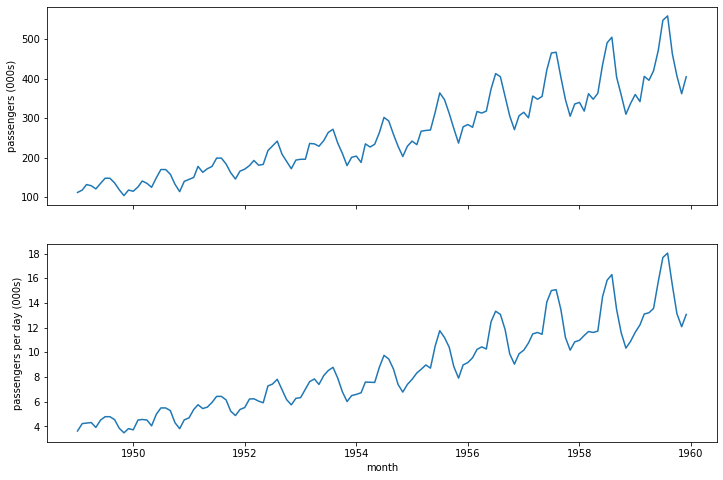

In [18]:
train_adj = train / train.index.days_in_month
test_adj = train / train.index.days_in_month

#plot the adjusted and unadjusted series
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].figsize = (12, 10)

axes[0].plot(train)
axes[0].set(ylabel='passengers (000s)');

axes[1].plot(train_adj)
axes[1].set(xlabel='month', ylabel='passengers per day (000s)');


#### Explore subcomponents in series.

Before performing a forecast it is worth decomposing the time series into its components of trend, seasonality and noise.

* statsmodels has function called `seasonal_decompose()` for this task

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [31]:
sd_result = seasonal_decompose(train_adj, model='multiplicative')

This is a naive decomposition. More sophisticated methods should be preferred.

The additive model is Y[t] = T[t] + S[t] + e[t]

The multiplicative model is Y[t] = T[t] * S[t] * e[t]

The seasonal component is first removed by applying a convolution filter to the data. The average of this smoothed series for each period is the returned seasonal component.

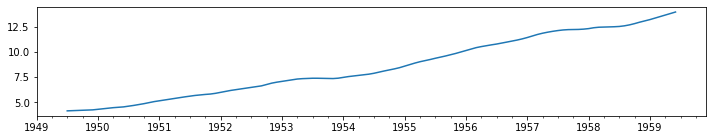

In [32]:
ax = sd_result.trend.plot(figsize=(12,2))

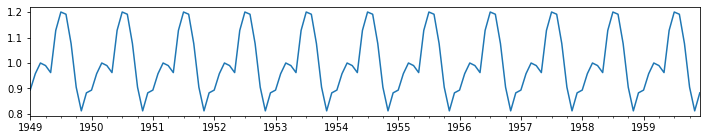

In [33]:
ax = sd_result.seasonal.plot(figsize=(12,2))

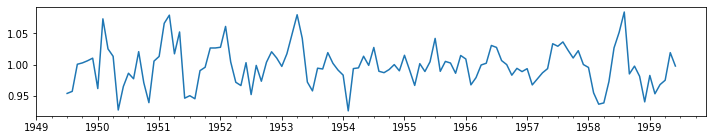

In [34]:
ax = sd_result.resid.plot(figsize=(12,2))

## Naive forecasting

We need a baseline (as always!) to know if our more complex models are any use! We explore two here:
* seasonal naive - a model which just takes the same period from the previous season. ( in this case the same month last year)
* naive - just carry forward the last value in the series

Given the strong seasonal component that was confirmed by the seasonal decomposition it may be a good idea to use a **seasonal naive** forecasting method.  This is part of the 'carry forward previous values' family of *naive* forecasting methods.  In general, if we have data with period $k$ are at time $t$ and we are predicting time $Y_{t+1}$ then we simply carry forward the value from $Y_{t+1-k}$. In other words we have yearly data so we just take the value from the same month last year.

In [35]:
from forecast.baseline import Naive1, SNaive

HORIZON = 12 # we plan to make forecasts for the following 12 months
PERIOD = 12 # period is the period of seasonality we expect

In [36]:
# using seasonal naive
snf = SNaive(period=PERIOD)
snf.fit(train_adj)
insample_predictions = snf.fittedvalues

To see what this is doing lets plot its predictions for the whole TRAIN data set to which it has been fitted.

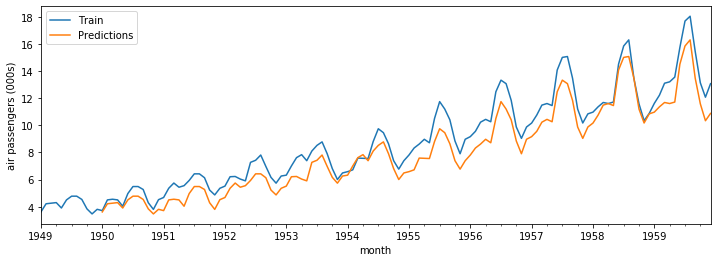

In [37]:
ax = train_adj.plot(figsize=(12,4))
insample_predictions.plot(ax=ax)
ax.set(xlabel='month', ylabel='air passengers (000s)');
ax.legend(['Train', 'Predictions'])

Plotting the **residuals** can give us information about how the model is performing and the errors it is making.  Sometimes there are reffered to as **in sample** diagnostics. This just means we are looking at diagnostics of data which has been used to fit the model. 

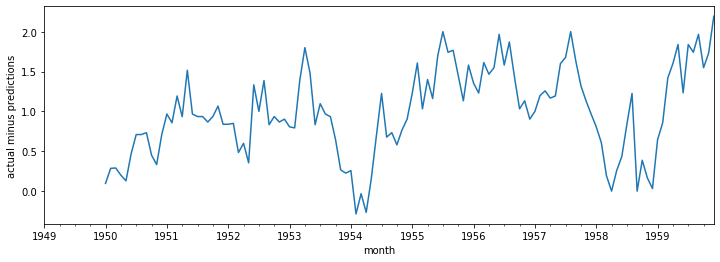

In [40]:
#Train minnus train_prediction

ax = snf.resid.plot(figsize=(12,4))
ax.set(xlabel='month', ylabel='actual minus predictions');

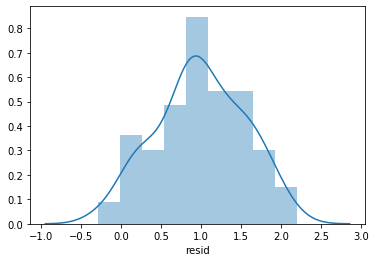

In [19]:
sns.distplot(snf.resid.dropna())

In [44]:
print(snf.resid.dropna().describe())

count    120.000000
mean       0.990224
std        0.550262
min       -0.285714
25%        0.669355
50%        0.951075
75%        1.404839
max        2.193548
Name: resid, dtype: float64


https://machinelearningmastery.com/visualize-time-series-residual-forecast-errors-with-python/

#### evaluating error

In the past we have done this. 

In [45]:
from sklearn.metrics import mean_squared_error

In [46]:
np.sqrt(mean_squared_error(train_adj[PERIOD:], insample_predictions[PERIOD:])) # we do not have predictions for the first period

1.1317282236397845

For timeseries there are other approaches...

RMSE and MAE are called 'scale dependent' measures as the units and magnitude are specific to the problem and context.  An alternative approach is to use a scale invariant measure such as the **mean absolute percentage error (MAPE)**

The percentage error is given by $p_t = 100e_t/y_t$ where $e_t$ is the error in predicting $y_t$.  Therefore, MAPE = $mean(|p_t|)$. A limitation of MAPE is that it is inflated when the denominator is small relative to the absolute forecast error (such in the case of outliers or extreme unexpected events). It is also penalises negative errors more than positive errors.  A consequence of this property is that MAPE can lead to selecting a model that tends to under forecast.  The two following examples illustrate the issue. $$APE_{1} = \left| \frac{y_t - \hat{y_t}}{y_t} \right|= \left| \frac{150 - 100}{150} \right| = \frac{50}{150} = 33.33\%$$  

$$APE_{2} = \left| \frac{100 - 150}{100} \right| = \frac{50}{100} = 50\%$$

In [47]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
mean_absolute_percentage_error(train_adj[PERIOD:], insample_predictions[PERIOD:])

11.377828929635351

## Task: Perform the same analysis for the naive prediction

* Have a go at using the `Naive1()` class.  It follows the same pattern as SNaive interface.  Instantiate a class.  call the `.fit(y_train)` method and then use the `.fittedvalues` and `.resid` properties for diagnostics.  
* Calculate the in-sample RMSE and MAPE
* What happens to the insample residuals if you fit the raw training data to the model?

In [53]:
# using seasonal naive
naive1 = Naive1()
naive1.fit(train_adj)
insample_predictions = naive1.fittedvalues




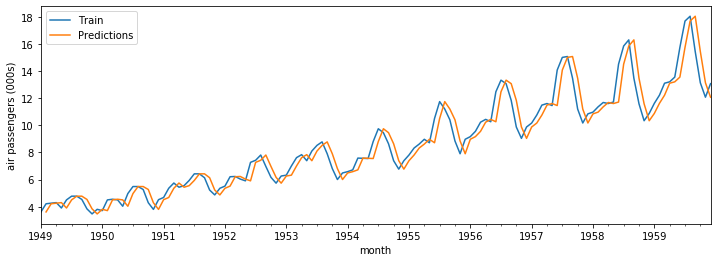

In [54]:
ax = train_adj.plot(figsize=(12,4))
insample_predictions.plot(ax=ax)
ax.set(xlabel='month', ylabel='air passengers (000s)');
ax.legend(['Train', 'Predictions'])

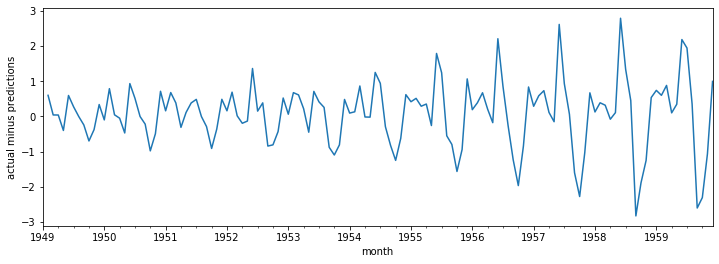

In [57]:
#Train minnus train_prediction

ax = naive1.resid.plot(figsize=(12,4))
ax.set(xlabel='month', ylabel='actual minus predictions');

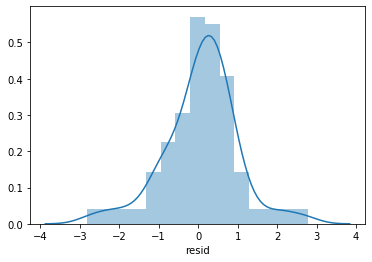

In [56]:
sns.distplot(naive1.resid.dropna())

In [58]:
mean_absolute_percentage_error(train_adj[PERIOD:], insample_predictions[PERIOD:])

7.862977325559717

NOTE: The predictions we made above are only for the next step (month) in each timeseries! (not for the next 12 months) This means they are not correctly evaluating the error that we need for the specific task at hand. You can imagine for the simple naive model that a 12 month prediction actually looks like a flat line (using the most recent value). We will see this later.

## ARIMA

Let's try an ARIMA model at last. Using a classical statsitical approach you would select the order of model which produces a model with acceptable residual plots (remember the first part of linear regression module?). Selecting the best model can also be done automatically using packages which do it for you! Wohoo! 🎉

The `pmdarima` package is an excellent forecasting library for building ARIMA models.  I recommend it over and above the options available in core `statsmodels` package.  It is easier to use and offers an `auto_arima()` function that iteratively searches for a model that minimises the **Akaike Information Criterion (AIC)**

* ${\displaystyle \mathrm {AIC} \,=\,2k-2\ln({\hat {L}})}$

where $k$ = number of parameters in the model and $\hat{L}$ is the maximum value of the likelihood function for the model.  A likelihood function measures the 'goodness' of fit of a model to data given a set of parameters.  

This looks very complicated at first, but all we need to remember that the models we are working with are very flexible. This means that we can easily create complex models that overfit. Recall that overfitting is when a model will predict the training data exceptionally well, but will perform poorly on out of sample data.  The form of AIC means that it rewards models that fit the training data well, but also penalises models with high $k$ (complicated models with lots of parameters).  That means that AIC will prefer simpler models - in turn reducing overfitting.  That's a great formaula for automatically selecting a good ARIMA forecasting model.

There's a large amount of theory about how to build an ARIMA model.  But modern applications tend to opt for the auto approach.

In [59]:
from pmdarima.arima import auto_arima

ARIMA models require data to be stationary. Stationarity includes that both the mean and variance do not change over time. ARIMA models can take into account an increasing mean over time, however not the variance. We therefore need another transformation. A log transformation will take care of this.

In [60]:
train_adj_log = np.log(train_adj)

Logarithms are useful because they are interpretable: changes in a log value are relative (or percentage) changes on the original scale. So if log base 10 is used, then an increase of 1 on the log scale corresponds to a multiplication of 10 on the original scale. Another useful feature of log transformations is that they constrain the forecasts to stay positive on the original scale.

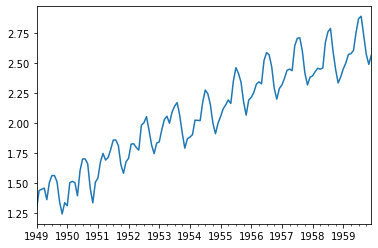

In [61]:
train_adj_log.plot()

In [62]:
#select a model that minimises AIC
arima_model = auto_arima(train_adj_log, seasonal=True, m=12, suppress_warnings=True)

Seasonal is fitting terms from one season before (P,D,Q,s). It makes ARIMA seasonal.

In [63]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 232.042
Date:                              Wed, 11 Mar 2020   AIC                           -454.083
Time:                                      11:00:21   BIC                           -440.146
Sample:                                           0   HQIC                          -448.423
                                              - 132                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0188      0.009      2.139      0.032       0.002       0.036
ar.L1          0.6045      0.083      7.274      0.000       0.442       0.767
ar.L2          0.2407      0.085      2.823      0.005       0.074       0.408
ma.S.L12      -0.5462      0.106     -5.167      0.000      -0.753      -0.339
sigma2         0.0012      0.000      7.856      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       43.01   Jarque-Bera (JB):                 5.68
Prob(Q):                              0.34   Prob(JB):                         0.06
Heteroskedasticity (H):               0.37   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

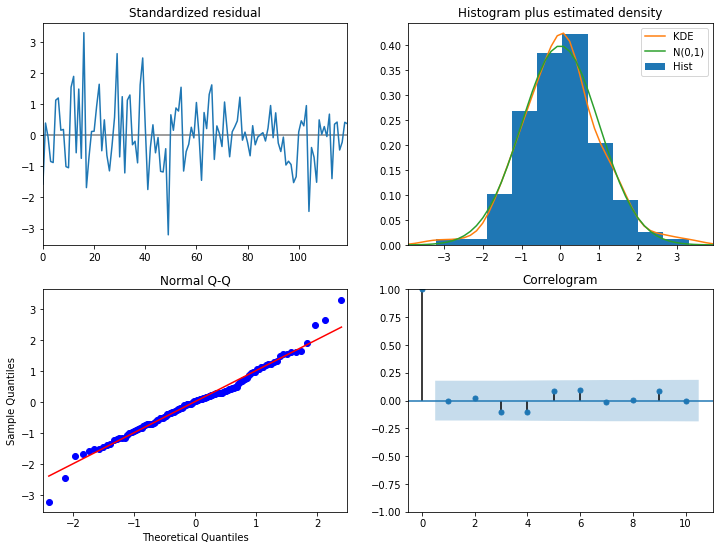

In [64]:
arima_model.plot_diagnostics(figsize=(12,9));

The best model selected is of order (2, 0, 0)x(0, 1, 1, 12) (and the residuals look acceptable). We will use these model in cross validation to estimate our model performance.

We can also specify a model with specific parameters as below.

In [65]:
from pmdarima.arima import ARIMA

In [66]:
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)

In [67]:
model.fit(train_adj_log)

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

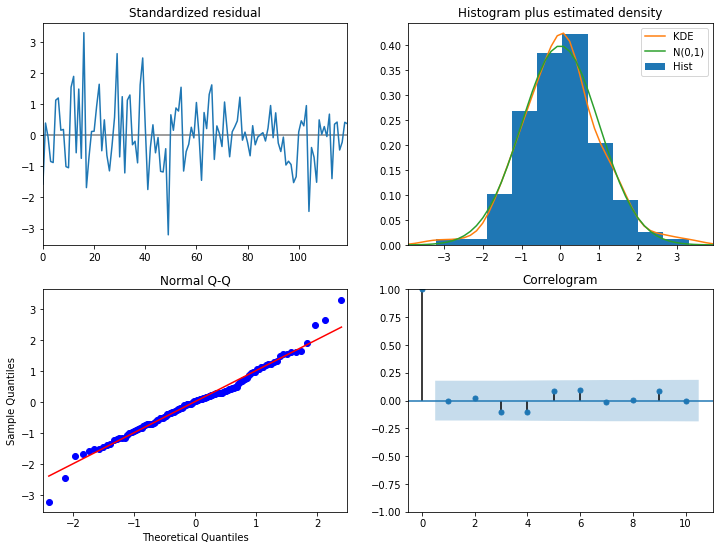

In [68]:
model.plot_diagnostics(figsize=(12,9));

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

## Time series cross-validation

In reality we would use some sort of cross validation. However, we must be careful when using time series which approach we use. We must be careful not to give hte model any information from the future that it would not otherwise have at the time of making a forecast. This means we cannot use the standard CV methods which randomise our data that we have used in the past.

In the classicial time series literature time series cross validation is called a **Rolling Forecasting Horizon**. The following code and output provide a simplified view of how rolling forecast horizons work in practice.

In [69]:
full_series = [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222, 1234, 3456]

test = full_series[-2:]
train = full_series[:-2]
print('full training set: {0}'.format(train))
print('hidden test set: {0}'.format(test))


def show_data_is_used_in_cv(train, min_train_size, horizon):
    '''
    Loop through training data and illustrate
    how it would be used in a rolling forecast approach
    to CV.  Assumes that user wants to take steps of 1 in each 
    fold.
    '''
    print('\n**data used in cross-validation**')
    print('**horizon = {}'.format(horizon))
    for i in range(len(train) - min_train_size - horizon + 1):
        print('fold:{0}'.format(i+1))
        print('training\t{0}'.format(train[:min_train_size+i]))
        print('validation\t{0}'.format(train[min_train_size+i:min_train_size+i+horizon]))


for horizon in range(1, 4):
    show_data_is_used_in_cv(train, min_train_size=4, horizon=horizon)

full training set: [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222]
hidden test set: [1234, 3456]

**data used in cross-validation**
**horizon = 1
fold:1
training	[2502, 2414, 2800, 2143]
validation	[2708]
fold:2
training	[2502, 2414, 2800, 2143, 2708]
validation	[1900]
fold:3
training	[2502, 2414, 2800, 2143, 2708, 1900]
validation	[2333]
fold:4
training	[2502, 2414, 2800, 2143, 2708, 1900, 2333]
validation	[2222]

**data used in cross-validation**
**horizon = 2
fold:1
training	[2502, 2414, 2800, 2143]
validation	[2708, 1900]
fold:2
training	[2502, 2414, 2800, 2143, 2708]
validation	[1900, 2333]
fold:3
training	[2502, 2414, 2800, 2143, 2708, 1900]
validation	[2333, 2222]

**data used in cross-validation**
**horizon = 3
fold:1
training	[2502, 2414, 2800, 2143]
validation	[2708, 1900, 2333]
fold:2
training	[2502, 2414, 2800, 2143, 2708]
validation	[1900, 2333, 2222]


## Timeseries CV with naive models on  airline data

In order to choose between our models we use CV to estimate how we think each will perform on new data.

### Naive models

In [70]:
#i've written a function to help with the cv of the baseline
from forecast.model_selection import time_series_cv

In [86]:
#it requires the data to be split into training and validation.
train, test = ts_train_test_split(airline, '1960-01-01')
train_adj = train / train.index.days_in_month
test_adj = train / train.index.days_in_month
trainCV_adj, valCV_adj = train_adj.iloc[:len(train_adj)//10], train_adj.iloc[len(train_adj)//10:]

snf = SNaive(period=PERIOD)

cv_scores = time_series_cv(snf, 
                           error_func=mean_absolute_percentage_error,
                           train=trainCV_adj,
                           val=valCV_adj,
                           horizons=[12],
                           step=1)

In [87]:
cv_scores = pd.DataFrame(cv_scores)
cv_scores.describe()

,0
count,108.000000
mean,13.502727
std,4.973117
min,3.139441
25%,9.485411
50%,14.605431
75%,17.502228
max,22.355970


In [88]:
naive1 = Naive1()

cv_scores = time_series_cv(naive1, 
                           error_func=mean_absolute_percentage_error,
                           train=trainCV_adj,
                           val=valCV_adj,
                           horizons=[12],
                           step=1)

In [89]:
cv_scores = pd.DataFrame(cv_scores)
cv_scores.describe()

,0
count,108.000000
mean,16.907448
std,6.934029
min,7.826801
25%,11.892280
50%,15.113103
75%,20.533629
max,45.333765


The prediction is better for the seasonal-naive forecast. We would choose this as our baseline.

### CV with ARIMA

In [90]:
from pmdarima.arima import ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

In [91]:
#manually create the arima model
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)

In [92]:
cv = RollingForecastCV(h=HORIZON, step=10) # initially uses 1/3 of the training size

In [93]:
#for cv need all of the training data joined together.
airline_adj = airline / airline.index.days_in_month
# airline_adj = np.log(airline_adj) # transform
train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test) # get logged values for arima model

cv_results = cross_val_score(model, train_log, cv=cv, scoring=mean_absolute_percentage_error)

In [122]:
model.get_params

<bound method BaseEstimator.get_params of ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)>

44 (56) -> 54 (66) -> 64 (76) -> 74 (86) -> 84 (96) -> 94 (106) -> 104 (116) -> 114 (126)

In [94]:
#how many splits did we get?
len(cv_results)

8

In [96]:
cv_results

array([1.43358078, 4.50095854, 1.01222548, 1.23014143, 0.7365362 ,
       0.54629522, 3.06556897, 2.2554689 ])

In [95]:
pd.DataFrame(cv_results).dropna().describe()

,0
count,8.000000
mean,1.847597
std,1.355860
min,0.546295
25%,0.943303
50%,1.331861
75%,2.457994
max,4.500959


This is a far better model that either of the naive results. We would choose this model over the others. Is it suitable for use in practice?.... ca depend...

**TASK**
* go back and try different step values in the RollingForecastCV
* What changes?
* In each case what size is the data is the model training on?

In [102]:
def ARIMA_model(HORIZON,step):
    #manually create the arima model
    model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)

    cv = RollingForecastCV(h=HORIZON, step=step) # initially uses 1/3 of the training size
    #for cv need all of the training data joined together.
    airline_adj = airline / airline.index.days_in_month
    # airline_adj = np.log(airline_adj) # transform
    train, test = ts_train_test_split(airline_adj, '1960-01-01')
    train_log, test_log = np.log(train), np.log(test) # get logged values for arima model

    cv_results = cross_val_score(model, train_log, cv=cv, scoring=mean_absolute_percentage_error)


    return pd.DataFrame(cv_results).dropna().describe()

In [104]:
# The step defines how many months you skip for each cv
# The horieon defines the length of the validation set

ARIMA_model(1,12)

,0
count,8.000000
mean,1.322871
std,1.097813
min,0.246600
25%,0.462844
50%,1.016500
75%,1.966940
max,3.416175


In [136]:
ARIMA_model(12,2)

,0
count,38.000000
mean,1.948897
std,1.246960
min,0.546295
25%,0.923683
50%,1.407568
75%,2.934512
max,4.605887


In [105]:
ARIMA_model(24,12)

,0
count,6.000000
mean,2.572107
std,1.551942
min,0.724627
25%,1.425925
50%,2.378389
75%,3.812202
max,4.552661


In [106]:
ARIMA_model(1,1)

,0
count,87.000000
mean,1.154766
std,1.097647
min,0.008427
25%,0.382889
50%,0.865357
75%,1.655843
max,7.321518


In [107]:
ARIMA_model(2,2)

,0
count,43.000000
mean,1.254770
std,1.023156
min,0.116286
25%,0.590597
50%,1.014755
75%,1.552729
max,4.964043


In [108]:
ARIMA_model(1,2)

,0
count,44.000000
mean,1.037201
std,0.889593
min,0.055213
25%,0.273658
50%,0.669158
75%,1.499412
max,3.416175


In [109]:
ARIMA_model(1,5)

,0
count,18.000000
mean,1.284727
std,0.928977
min,0.240445
25%,0.414797
50%,1.236621
75%,1.940604
max,3.420660


In [110]:
ARIMA_model(2,1)

,0
count,86.000000
mean,1.301910
std,1.028500
min,0.116286
25%,0.568919
50%,1.067605
75%,1.700187
max,5.248746


In [111]:
ARIMA_model(6,1)

,0
count,82.000000
mean,1.643993
std,1.195537
min,0.473493
25%,0.796927
50%,1.313525
75%,2.028492
max,5.943531


For each succesive validations, the size of the data it is training on (originally 44 - 1/3 of original train) increases by step.<br>
$$L_{val,i}=L_{0}+i*step$$

# Predictions and evaluation on the TEST

In [112]:
airline.tail()

1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, dtype: float64

In [113]:
train.tail()

1959-08-01    18.032258
1959-09-01    15.433333
1959-10-01    13.129032
1959-11-01    12.066667
1959-12-01    13.064516
Freq: MS, dtype: float64

In [115]:
# predict 12-steps ahead with naive models
naive1 = Naive1()

HORIZON = 12
naive1.fit(train)
naive1_preds = naive1.predict(horizon=HORIZON)


snf = SNaive(period=PERIOD)
snf.fit(train)
snf_preds = snf.predict(horizon=HORIZON)

In [125]:
# predict 12 steps ahead with arima
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)
model.fit(train_log)
arima_preds = model.predict(12)

#### need to back transform the log traisform
arima_preds = np.exp(arima_preds)

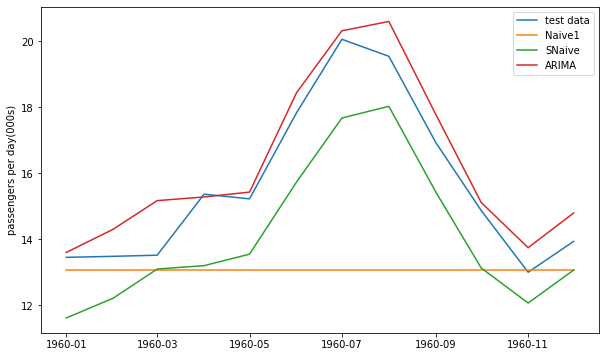

In [126]:
#plot the model predictions
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

axes.plot(test)
axes.plot(pd.Series(naive1_preds, index=test.index));
axes.plot(pd.Series(snf_preds, index=test.index));
axes.plot(pd.Series(arima_preds, index=test.index));
axes.set(ylabel='passengers per day(000s)');
axes.legend(['test data', 'Naive1', 'SNaive','ARIMA']);

## Produce final forecast with chosen model

We want to predict the next 12 steps after the data we currently have.

In [127]:
# fit arima model to whole time series
airline_log = np.log(airline_adj)
model.fit(airline_log)

#make predictions for following 12 periods
final_forecast, cis = model.predict(HORIZON, return_conf_int=True, alpha=0.05)

#### need to back transform the log
final_forecast = np.exp(final_forecast)
cis = np.exp(cis)

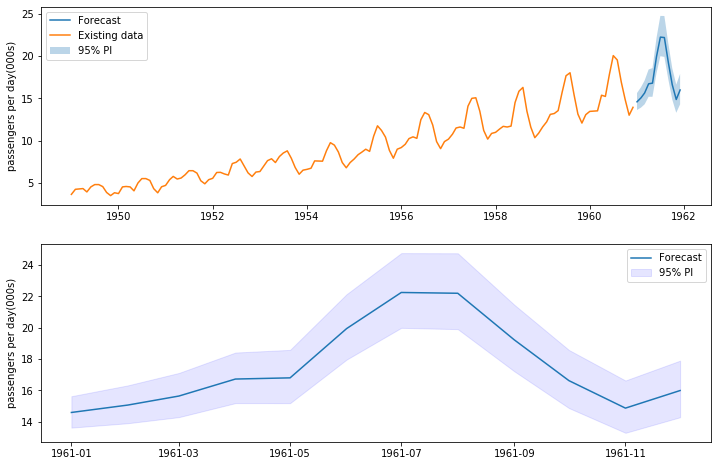

In [137]:
#create an datetime index for the forecast horizon
forecast_index = pd.date_range(start='1961-01-01', periods=HORIZON, freq='MS')

#plot the model with 90% predictions intervals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(pd.Series(final_forecast, index=forecast_index));
axes[0].plot(airline_adj)


axes[0].set(ylabel='passengers per day(000s)');

limits = pd.DataFrame(cis, index=forecast_index, columns=['lower', 'upper'])
axes[0].fill_between(forecast_index, limits['lower'], limits['upper'], 
                  alpha=.3, 
                  label='95% PI')

axes[0].legend([ 'Forecast','Existing data', '95% PI']);



axes[1].plot(pd.Series(final_forecast, index=forecast_index));
axes[1].set(ylabel='passengers per day(000s)');

axes[1].fill_between(forecast_index, limits['lower'], limits['upper'], 
                  alpha=.1, 
                  label='95% PI', color='blue')

axes[1].legend(['Forecast', '95% PI']);

In [130]:
pd.DataFrame(cis, index=forecast_index, columns=['lower', 'upper'])

,lower,upper
1961-01-01,13.616919,15.624606
1961-02-01,13.899096,16.318288
1961-03-01,14.288434,17.111363
1961-04-01,15.183822,18.416695
1961-05-01,15.181898,18.587759
1961-06-01,17.965392,22.145707
1961-07-01,19.994895,24.771921
1961-08-01,19.912485,24.762532
1961-09-01,17.219004,21.473284
1961-10-01,14.867467,18.579997


# Excercise 1 - skins

The Lynx dataset records the number of skins of predators (lynx) that were collected over many years by the Hudson’s Bay Company (1821 - 1934). It’s commonly used for time-series benchmarking (Brockwell and Davis - 1991). 

For this excercise you must imagine that you are alive in 1934, that you are not concerned about hunting large animals for personal gain, and most strangely you have access to a modern computer...

The Hudson's Bay Company wishes you to make a forecast for the number of animal skins it will trade over next 20 years so it can plan its human resources. You must:

* Make an ARIMA model that predicts the number of skins for the next 20 years following the data set.
* Evaluate the estimated accuracy of your model using a suitable method
* Compare you model to a naive model

In [132]:
from pmdarima.datasets import load_lynx

In [73]:
#### solution here 



